In [ ]:
!pip install --upgrade s3fs fsspec

In [2]:
import pandas as pd

path = "s3://artem-ml-dataset/train_age.csv"
df = pd.read_csv(path, dtype={30: str})
df.head()

,target,CALCULATION_METHOD_ID,calls_count_in_weekdays,calls_duration_in_weekdays,calls_count_out_weekdays,calls_duration_out_weekdays,calls_count_in_weekends,calls_duration_in_weekends,calls_count_out_weekends,calls_duration_out_weekends,...,ttSMS,ttt.ua,uklon,ukrazom.or,ukrazom.org,ukrmir,upgood,www.add.ua,xiaomi,ya888ya
0,5,2,9.00,24.544,8.13,26.562,5.00,23.792,5.00,29.083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6,2,0.65,5.451,0.35,1.463,0.25,0.577,0.38,0.623,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6,1,0.00,0.000,0.00,0.000,0.00,0.000,0.13,0.052,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1,34.43,50.256,27.09,48.209,10.38,19.048,9.75,22.977,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,1,3.57,11.384,1.87,4.562,2.00,2.208,1.88,4.123,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
print("=== 1. РОЗМІРНІСТЬ ДАТАСЕТУ ===")
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

=== 1. РОЗМІРНІСТЬ ДАТАСЕТУ ===
Rows: 210000, Columns: 1294


In [4]:
print("\n=== 2. ТИПИ ДАНИХ ТА КОЛОНКИ ===")
print(df.dtypes)


=== 2. ТИПИ ДАНИХ ТА КОЛОНКИ ===
target                          int64
CALCULATION_METHOD_ID           int64
calls_count_in_weekdays       float64
calls_duration_in_weekdays    float64
calls_count_out_weekdays      float64
                               ...   
ukrmir                        float64
upgood                        float64
www.add.ua                    float64
xiaomi                        float64
ya888ya                       float64
Length: 1294, dtype: object


In [5]:
print("\n=== 3. ПРОПУЩЕНІ ЗНАЧЕННЯ (NaN) ===")
missing = df.isnull().sum()
print(missing[missing > 0])


=== 3. ПРОПУЩЕНІ ЗНАЧЕННЯ (NaN) ===
Автосервис / Автотовары    57301
Город / Власть             57301
Дети_1                     57301
Другие услуги              57301
Электроэнергия             57301
                           ...  
ukrmir                      8599
upgood                      8599
www.add.ua                  8599
xiaomi                      8599
ya888ya                     8599
Length: 1178, dtype: int64


In [6]:
print("\n=== 4. СТАТИСТИКА (ЧИСЛОВІ ДАНІ) ===")
print(df.describe())


=== 4. СТАТИСТИКА (ЧИСЛОВІ ДАНІ) ===
              target  CALCULATION_METHOD_ID  calls_count_in_weekdays  \
count  210000.000000          210000.000000            210000.000000   
mean        4.226167               1.499833                 5.001646   
std         1.218251               0.500001                 8.800330   
min         1.000000               1.000000                 0.000000   
25%         3.000000               1.000000                 1.220000   
50%         4.000000               1.000000                 3.350000   
75%         5.000000               2.000000                 6.700000   
max         6.000000               2.000000              1406.830000   

       calls_duration_in_weekdays  calls_count_out_weekdays  \
count               210000.000000             210000.000000   
mean                    11.138305                  5.222601   
std                     13.933017                 10.969235   
min                      0.000000                  0.000000  

In [7]:
print("\n=== 5. СТАТИСТИКА (КАТЕГОРІАЛЬНІ ДАНІ) ===")
try:
    print(df.describe(include=['object', 'category']).T)
except ValueError:
    print("Немає категоріальних колонок або вони не розпізнані.")


=== 5. СТАТИСТИКА (КАТЕГОРІАЛЬНІ ДАНІ) ===
                      count  unique                               top    freq
Oblast_post_HOME     210000      29                              Київ   30204
Raion_post_HOME      210000     549                              Київ   30204
City_post_HOME       210000    3256                              Київ   30204
Oblast_post_WORK     210000      29                              Київ   32837
Raion_post_WORK      210000     549                              Київ   32837
City_post_WORK       210000    3216                              Київ   32837
device_brand         210000     378                           Samsung   52418
device_model         210000    4632                                 0   17575
software_os_vendor   210000      18                            Google  118112
software_os_name     210000      32                           Android  117997
software_os_version  210000      73                                 0   66820
device_type_rus     

In [8]:
import numpy as np

print(f"Початковий розмір: {df.shape}")
print(f"Кількість пропусків до очищення: {df.isnull().sum().sum()}")

Початковий розмір: (210000, 1294)
Кількість пропусків до очищення: 28836206


In [9]:
# ВИДАЛЕННЯ ТЕХНІЧНИХ КОЛОНОК
if 'user_hash' in df.columns:
    df = df.drop(columns=['user_hash'])
    print("- Видалено колонку 'user_hash'")

# ВИДАЛЕННЯ КОНСТАНТНИХ КОЛОНОК
print("Пошук колонок, які мають лише одне значення (константні)...")

# Знаходимо колонки, де кількість унікальних значень == 1
const_cols = [col for col in df.columns if df[col].nunique() == 1]

print(f"Знайдено {len(const_cols)} константних колонок.")
print(f"Приклади сміття: {const_cols[:5]}")

if len(const_cols) > 0:
    df = df.drop(columns=const_cols)
    print("Константні колонки видалено.")
else:
    print("Константних колонок немає, всі несуть хоч якусь інформацію.")

print(f"Фінальний розмір датасету: {df.shape}")

- Видалено колонку 'user_hash'
Пошук колонок, які мають лише одне значення (константні)...
Знайдено 5 константних колонок.
Приклади сміття: ['AKCIYA', 'Golka', 'LAIM', 'PROVIDNA', 'TAXI BREND']
Константні колонки видалено.
Фінальний розмір датасету: (210000, 1288)


In [10]:
# ОБРОБКА ПРОПУСКІВ

# Якщо немає даних про трафік (NaN), значить активність = 0.
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
numeric_cols = [c for c in numeric_cols if c != 'target']

print(f"- Заповнення нулями {len(numeric_cols)} числових колонок...")
df[numeric_cols] = df[numeric_cols].fillna(0)

# Категоріальні колонки -> Заповнюємо 'Unknown'
cat_cols = df.select_dtypes(include=['object', 'category']).columns

print(f"- Заповнення 'Unknown' для {len(cat_cols)} текстових колонок...")
df[cat_cols] = df[cat_cols].fillna('Unknown')
df[cat_cols] = df[cat_cols].replace(0, 'Unknown')
df[cat_cols] = df[cat_cols].replace('0', 'Unknown')

- Заповнення нулями 1274 числових колонок...
- Заповнення 'Unknown' для 13 текстових колонок...


In [11]:
# ФІНАЛЬНА ПЕРЕВІРКА
missing_now = df.isnull().sum().sum()
print(f"Залишилось пропусків: {missing_now}")

if missing_now == 0:
    print("Дані повністю чисті.")
else:
    print("Щось пішло не так.")

Залишилось пропусків: 0
Дані повністю чисті.


In [12]:
# ЗБЕРЕЖЕННЯ РЕЗУЛЬТАТУ
output_file = 'vodafone_age_cleaned_sprint1.csv'
df.to_csv(output_file, index=False)
print(f"Файл збережено: {output_file}")

Файл збережено: vodafone_age_cleaned_sprint1.csv


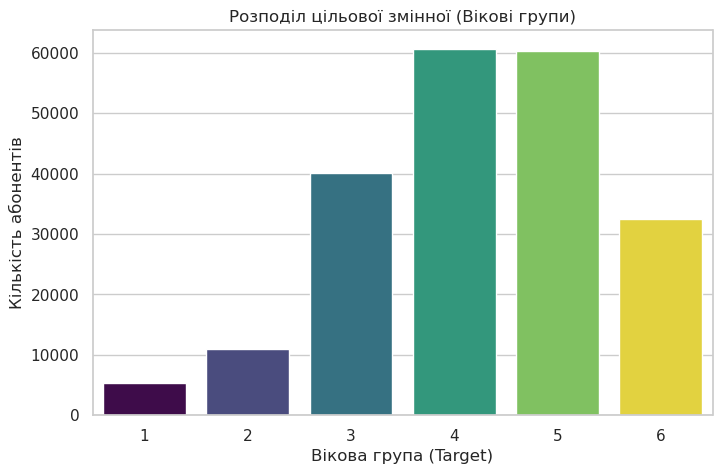

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Розподіл таргету (Вікові групи)
plt.figure(figsize=(8, 5))
sns.countplot(x='target', data=df, hue='target', legend=False, palette='viridis')
plt.title('Розподіл цільової змінної (Вікові групи)')
plt.xlabel('Вікова група (Target)')
plt.ylabel('Кількість абонентів')
plt.show()


<Figure size 1400x700 with 0 Axes>

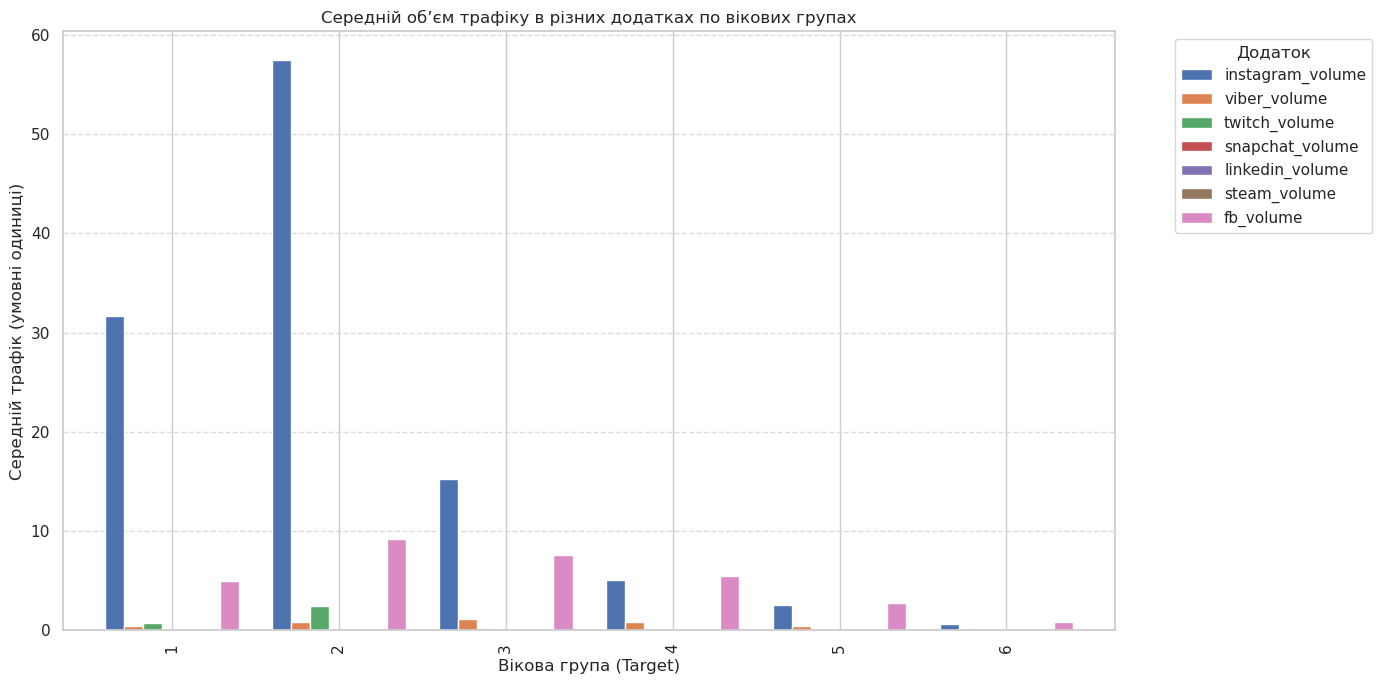

Середні значення трафіку:
        instagram_volume  viber_volume  twitch_volume  snapchat_volume  \
target                                                                   
1              31.658663      0.462035       0.756022         0.072513   
2              57.451449      0.903826       2.459765         0.077444   
3              15.235616      1.127139       0.292042         0.015543   
4               5.110394      0.830763       0.056018         0.009683   
5               2.558627      0.483503       0.032973         0.006282   
6               0.618082      0.200084       0.007919         0.001036   

        linkedin_volume  steam_volume  fb_volume  
target                                            
1              0.005626      0.002662   4.942938  
2              0.031688      0.004794   9.186730  
3              0.059646      0.000826   7.572531  
4              0.030453      0.000327   5.522783  
5              0.009175      0.000097   2.782794  
6              0.001160 

In [14]:
# 2. Специфічні додатки vs Вік

# Обираємо маркери різних поколінь
age_markers = [
    'instagram_volume',  # Молодь/Середній
    'viber_volume',      # Старші (гіпотеза)
    'twitch_volume',     # Геймери/Молодь
    'snapchat_volume',   # Підлітки/Молодь
    'linkedin_volume',   # Робота
    'steam_volume',      # Ігри
    'fb_volume'          # Facebook (часто старші за Instagram)
]

pivot = df.groupby('target')[age_markers].mean()
    
# Малюємо графік
plt.figure(figsize=(14, 7))
    
pivot.plot(kind='bar', width=0.8, figsize=(14, 7))
    
plt.title('Середній об’єм трафіку в різних додатках по вікових групах')
plt.ylabel('Середній трафік (умовні одиниці)')
plt.xlabel('Вікова група (Target)')
plt.legend(title='Додаток', bbox_to_anchor=(1.05, 1), loc='upper left') # Легенда збоку
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
    
print("Середні значення трафіку:")
print(pivot)

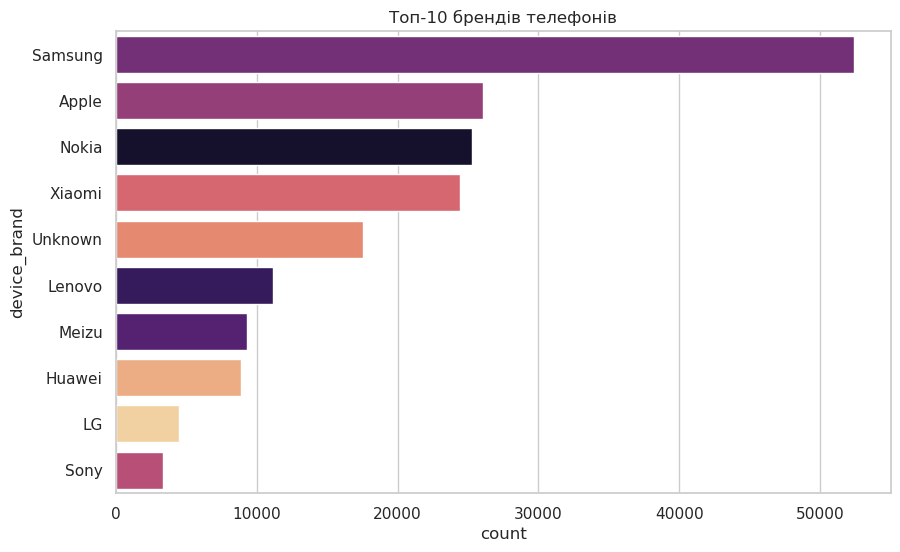

In [15]:
# 3. Топ брендів телефонів
plt.figure(figsize=(10, 6))
top_devices = df['device_brand'].value_counts().head(10).index
sns.countplot(y='device_brand', data=df[df['device_brand'].isin(top_devices)], 
              order=top_devices, hue='device_brand', legend=False, palette='magma')
plt.title('Топ-10 брендів телефонів')
plt.show()